# Modélisation Prédictive des Loyers en France

Ce projet a pour objectif de prédire le **loyer au mètre carré (€/m²)** à partir de caractéristiques des logements et de leur environnement, en s’appuyant sur des **techniques de Machine Learning** appliquées à des données publiques françaises.

---

##  Structure du projet

```bash
.
├── data/                          # Données brutes et nettoyées
│   ├── loyers_raw.csv
│   └── loyers_clean.csv
│
├── figures/                       # Graphiques générés
│   ├── hist_loyer_m2.png
│   ├── boxplot_type_habitat.png
│   ├── heatmap_correlation.png
│   └── importances_rf_lasso.png
│
├── top_erreurs_random_forest.xlsx # Fichier Excel des plus fortes erreurs
│
├── loyers_obtain.py              # Script d’extraction et de fusion des données
├── loyers_scrub.py               # Script de nettoyage des données
├── loyers_explore.py             # Analyse exploratoire (EDA)
├── loyers_modelisation.py        # Modélisation prédictive (ML)
└── README.md



In [1]:
!zip -r projet_loyers.zip data figures top_erreurs_random_forest.xlsx *.py README.md


	zip warning: name not matched: data
	zip warning: name not matched: figures
	zip warning: name not matched: top_erreurs_random_forest.xlsx
	zip warning: name not matched: *.py
	zip warning: name not matched: README.md

zip error: Nothing to do! (try: zip -r projet_loyers.zip . -i data figures top_erreurs_random_forest.xlsx *.py README.md)


In [2]:
!ls



sample_data


In [ ]:
import os
import requests
import pandas as pd

# ==============================
# 📁 Dossier et nom du fichier
# ==============================
DATA_DIR = "data"
RAW_FILE = os.path.join(DATA_DIR, "loyers_raw.csv")

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

# ==============================
#  1. Données depuis OpenDataSoft (JSON)
# ==============================
ODS_API_URL = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/resultats-nationaux-des-observatoires-locaux-des-loyers-france/exports/json"

try:
    response = requests.get(ODS_API_URL)
    response.raise_for_status()
    df_ods = pd.DataFrame(response.json())
    print("✅ Données OpenDataSoft chargées avec succès.")
except requests.exceptions.RequestException as e:
    print(f"❌ Erreur OpenDataSoft : {e}")
    df_ods = pd.DataFrame()

# ==============================
#  2. Données Data.gouv.fr (CSV 2014–2024)
# ==============================
DATA_GOUV_CSV_URLS = [
    "https://www.data.gouv.fr/fr/datasets/r/13d660de-6108-4df6-8a54-1828a991a186",
    "https://www.data.gouv.fr/fr/datasets/r/3da6ba68-1f1e-4c49-a7e8-f521bd099599",
    "https://www.data.gouv.fr/fr/datasets/r/2ae4fb01-c69d-4a4d-bd09-f02c1b02882e",
    "https://www.data.gouv.fr/fr/datasets/r/422b3274-114d-4abe-850c-dfc0c69b981f",
    "https://www.data.gouv.fr/fr/datasets/r/f0f3abb1-2aed-4301-a44a-b14b43d73e1a",
    "https://www.data.gouv.fr/fr/datasets/r/5dcdae40-91b5-44ba-8ffc-65af94b61c6a",
    "https://www.data.gouv.fr/fr/datasets/r/4f1363af-28d9-4ec2-bdad-88f8b51fd7f2",
    "https://www.data.gouv.fr/fr/datasets/r/e30cb3ba-e1ca-4bec-b6ea-3cb751d6b862",
    "https://www.data.gouv.fr/fr/datasets/r/1fee314d-c278-424f-a029-a74d877eb185",
    "https://www.data.gouv.fr/fr/datasets/r/15d902ed-4dc3-457d-9c5d-bfe1151cb573",
    "https://www.data.gouv.fr/fr/datasets/r/42aaf838-46c9-4434-95a9-00173c6d4627",
]

df_gouv_list = []
for url in DATA_GOUV_CSV_URLS:
    try:
        df = pd.read_csv(url, delimiter=";", encoding="ISO-8859-1", low_memory=False)
        df_gouv_list.append(df)
        print(f"✅ Données chargées : {url}")
    except Exception as e:
        print(f"❌ Erreur Data.gouv ({url}): {e}")

df_gouv = pd.concat(df_gouv_list, ignore_index=True) if df_gouv_list else pd.DataFrame()

# ==============================
#  3. Fusion finale
# ==============================
df_loyers = pd.concat([df_ods, df_gouv], ignore_index=True)

# Nettoyage basique
df_loyers.columns = df_loyers.columns.str.strip()

# ==============================
#  4. Sauvegarde finale
# ==============================
if not df_loyers.empty:
    df_loyers.to_csv(RAW_FILE, index=False, encoding="ISO-8859-1")
    print(f"\n✅ Données fusionnées sauvegardées sous '{RAW_FILE}'.")
    print("🔍 Aperçu des 5 premières lignes :")
    print(df_loyers.head())
else:
    print("❌ Aucun fichier de loyers valide généré.")

✅ Données OpenDataSoft chargées avec succès.
✅ Données chargées : https://www.data.gouv.fr/fr/datasets/r/13d660de-6108-4df6-8a54-1828a991a186
✅ Données chargées : https://www.data.gouv.fr/fr/datasets/r/3da6ba68-1f1e-4c49-a7e8-f521bd099599
✅ Données chargées : https://www.data.gouv.fr/fr/datasets/r/2ae4fb01-c69d-4a4d-bd09-f02c1b02882e
✅ Données chargées : https://www.data.gouv.fr/fr/datasets/r/422b3274-114d-4abe-850c-dfc0c69b981f
✅ Données chargées : https://www.data.gouv.fr/fr/datasets/r/f0f3abb1-2aed-4301-a44a-b14b43d73e1a
✅ Données chargées : https://www.data.gouv.fr/fr/datasets/r/5dcdae40-91b5-44ba-8ffc-65af94b61c6a
✅ Données chargées : https://www.data.gouv.fr/fr/datasets/r/4f1363af-28d9-4ec2-bdad-88f8b51fd7f2
✅ Données chargées : https://www.data.gouv.fr/fr/datasets/r/e30cb3ba-e1ca-4bec-b6ea-3cb751d6b862
✅ Données chargées : https://www.data.gouv.fr/fr/datasets/r/1fee314d-c278-424f-a029-a74d877eb185
✅ Données chargées : https://www.data.gouv.fr/fr/datasets/r/15d902ed-4dc3-457d-9c5

In [ ]:
import os
import requests
import pandas as pd

# ==============================
# 📁 Dossier et nom du fichier
# ==============================
DATA_DIR = "data"
RAW_FILE = os.path.join(DATA_DIR, "loyers_raw.csv")

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

# ==============================
# 📌 1. Données depuis OpenDataSoft (JSON)
# ==============================
ODS_API_URL = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/resultats-nationaux-des-observatoires-locaux-des-loyers-france/exports/json"

try:
    response = requests.get(ODS_API_URL)
    response.raise_for_status()
    df_ods = pd.DataFrame(response.json())
    print("✅ Données OpenDataSoft chargées avec succès.")
except requests.exceptions.RequestException as e:
    print(f"❌ Erreur OpenDataSoft : {e}")
    df_ods = pd.DataFrame()

# ==============================
# 📌 2. Données Data.gouv.fr (CSV 2014–2024)
# ==============================
DATA_GOUV_CSV_URLS = [
    "https://www.data.gouv.fr/fr/datasets/r/13d660de-6108-4df6-8a54-1828a991a186",
    "https://www.data.gouv.fr/fr/datasets/r/3da6ba68-1f1e-4c49-a7e8-f521bd099599",
    "https://www.data.gouv.fr/fr/datasets/r/2ae4fb01-c69d-4a4d-bd09-f02c1b02882e",
    "https://www.data.gouv.fr/fr/datasets/r/422b3274-114d-4abe-850c-dfc0c69b981f",
    "https://www.data.gouv.fr/fr/datasets/r/f0f3abb1-2aed-4301-a44a-b14b43d73e1a",
    "https://www.data.gouv.fr/fr/datasets/r/5dcdae40-91b5-44ba-8ffc-65af94b61c6a",
    "https://www.data.gouv.fr/fr/datasets/r/4f1363af-28d9-4ec2-bdad-88f8b51fd7f2",
    "https://www.data.gouv.fr/fr/datasets/r/e30cb3ba-e1ca-4bec-b6ea-3cb751d6b862",
    "https://www.data.gouv.fr/fr/datasets/r/1fee314d-c278-424f-a029-a74d877eb185",
    "https://www.data.gouv.fr/fr/datasets/r/15d902ed-4dc3-457d-9c5d-bfe1151cb573",
    "https://www.data.gouv.fr/fr/datasets/r/42aaf838-46c9-4434-95a9-00173c6d4627",
]

df_gouv_list = []
for url in DATA_GOUV_CSV_URLS:
    try:
        df = pd.read_csv(url, delimiter=";", encoding="ISO-8859-1", low_memory=False)
        df_gouv_list.append(df)
        print(f"✅ Données chargées : {url}")
    except Exception as e:
        print(f"❌ Erreur Data.gouv ({url}): {e}")

df_gouv = pd.concat(df_gouv_list, ignore_index=True) if df_gouv_list else pd.DataFrame()

# ==============================
# 📌 3. Fusion finale
# ==============================
df_loyers = pd.concat([df_ods, df_gouv], ignore_index=True)

# Nettoyage basique
df_loyers.columns = df_loyers.columns.str.strip()

# ==============================
# 📌 4. Sauvegarde finale
# ==============================
if not df_loyers.empty:
    df_loyers.to_csv(RAW_FILE, index=False, encoding="ISO-8859-1")
    print(f"\n✅ Données fusionnées sauvegardées sous '{RAW_FILE}'.")
    print("🔍 Aperçu des 5 premières lignes :")
    print(df_loyers.head())
else:
    print("❌ Aucun fichier de loyers valide généré.")


✅ Données OpenDataSoft chargées avec succès.
✅ Données chargées : https://www.data.gouv.fr/fr/datasets/r/13d660de-6108-4df6-8a54-1828a991a186
✅ Données chargées : https://www.data.gouv.fr/fr/datasets/r/3da6ba68-1f1e-4c49-a7e8-f521bd099599
✅ Données chargées : https://www.data.gouv.fr/fr/datasets/r/2ae4fb01-c69d-4a4d-bd09-f02c1b02882e
✅ Données chargées : https://www.data.gouv.fr/fr/datasets/r/422b3274-114d-4abe-850c-dfc0c69b981f
✅ Données chargées : https://www.data.gouv.fr/fr/datasets/r/f0f3abb1-2aed-4301-a44a-b14b43d73e1a
✅ Données chargées : https://www.data.gouv.fr/fr/datasets/r/5dcdae40-91b5-44ba-8ffc-65af94b61c6a
✅ Données chargées : https://www.data.gouv.fr/fr/datasets/r/4f1363af-28d9-4ec2-bdad-88f8b51fd7f2
✅ Données chargées : https://www.data.gouv.fr/fr/datasets/r/e30cb3ba-e1ca-4bec-b6ea-3cb751d6b862
✅ Données chargées : https://www.data.gouv.fr/fr/datasets/r/1fee314d-c278-424f-a029-a74d877eb185
✅ Données chargées : https://www.data.gouv.fr/fr/datasets/r/15d902ed-4dc3-457d-9c5

In [ ]:
import os
import pandas as pd

# ==============================
# 📌 Définition des fichiers
# ==============================
DATA_DIR = "data"
RAW_FILE = os.path.join(DATA_DIR, "loyers_raw.csv")
CLEAN_FILE = os.path.join(DATA_DIR, "loyers_clean.csv")

# ==============================
# 📌 Chargement des données brutes
# ==============================
if not os.path.exists(RAW_FILE):
    print(f"❌ Fichier introuvable : {RAW_FILE}")
    exit()

df = pd.read_csv(RAW_FILE, delimiter=",", encoding="ISO-8859-1", low_memory=False)
print("✅ Données brutes chargées avec succès.")
print(f"🔍 Dimensions initiales : {df.shape}")

# ==============================
# 📌 Renommage des colonnes utiles
# ==============================
column_mapping = {
    "loyer_median": "loyer",
    "surface_moyenne": "surface",
    "nombre_pieces_homogene": "nombre_pieces"
}
df = df.rename(columns=column_mapping)

# ==============================
# 📌 Extraction de la variable nombre_pieces
# ==============================
def extraire_nombre_pieces(val):
    if isinstance(val, str):
        for part in val.split():
            try:
                return float(part.replace('P', ''))
            except:
                continue
    try:
        return float(val)
    except:
        return None

df["nombre_pieces"] = df["nombre_pieces"].apply(extraire_nombre_pieces)

# ==============================
# 📌 Vérification des colonnes essentielles
# ==============================
required_columns = ["loyer", "surface", "nombre_pieces"]
for col in required_columns:
    if col not in df.columns:
        print(f"❌ Colonne manquante : {col}")
        exit()

# ==============================
# 📌 Nettoyage des valeurs manquantes
# ==============================
df = df.dropna(subset=required_columns)
print(f"✅ Après suppression des NaN : {df.shape}")

# ==============================
# 📌 Conversion numérique
# ==============================
for col in required_columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=required_columns)
print(f"✅ Après conversion numérique : {df.shape}")

# ==============================
# 📌 Suppression des valeurs aberrantes
# ==============================
df = df[(df["loyer"] > 5) & (df["loyer"] < 10000)]
df = df[(df["surface"] > 5) & (df["surface"] < 500)]
print(f"✅ Après suppression des outliers : {df.shape}")

# ==============================
# 📌 Ajout du loyer au m²
# ==============================
df["loyer_m2"] = df["loyer"] / df["surface"]

# ==============================
# 📌 Sauvegarde
# ==============================
if len(df) == 0:
    print("❌ Plus aucune donnée après nettoyage. Vérifie les filtres.")
else:
    df.to_csv(CLEAN_FILE, index=False, encoding="ISO-8859-1")
    print(f"✅ Données nettoyées sauvegardées dans '{CLEAN_FILE}' ({len(df)} lignes).")


✅ Données brutes chargées avec succès.
🔍 Dimensions initiales : (134177, 29)
✅ Après suppression des NaN : (47101, 29)
✅ Après conversion numérique : (13336, 29)
✅ Après suppression des outliers : (13330, 29)


<ipython-input-9-92cb6cbc06e3>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors="coerce")


✅ Données nettoyées sauvegardées dans 'data/loyers_clean.csv' (13330 lignes).


✅ Données chargées : (13330, 30)

📊 Statistiques descriptives de 'loyer_m2' :
count    13330.000000
mean         0.284514
std          0.185197
min          0.054167
25%          0.147059
50%          0.227957
75%          0.403571
max          1.304348
Name: loyer_m2, dtype: float64


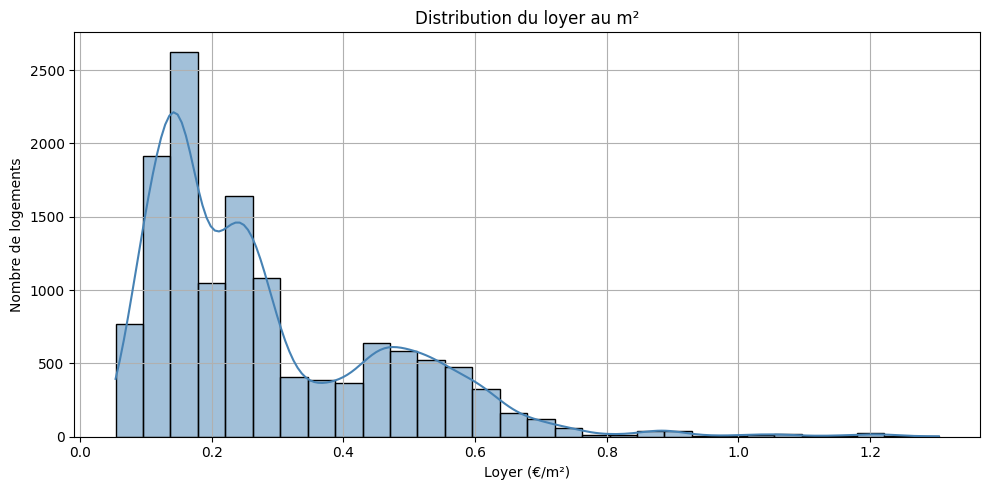

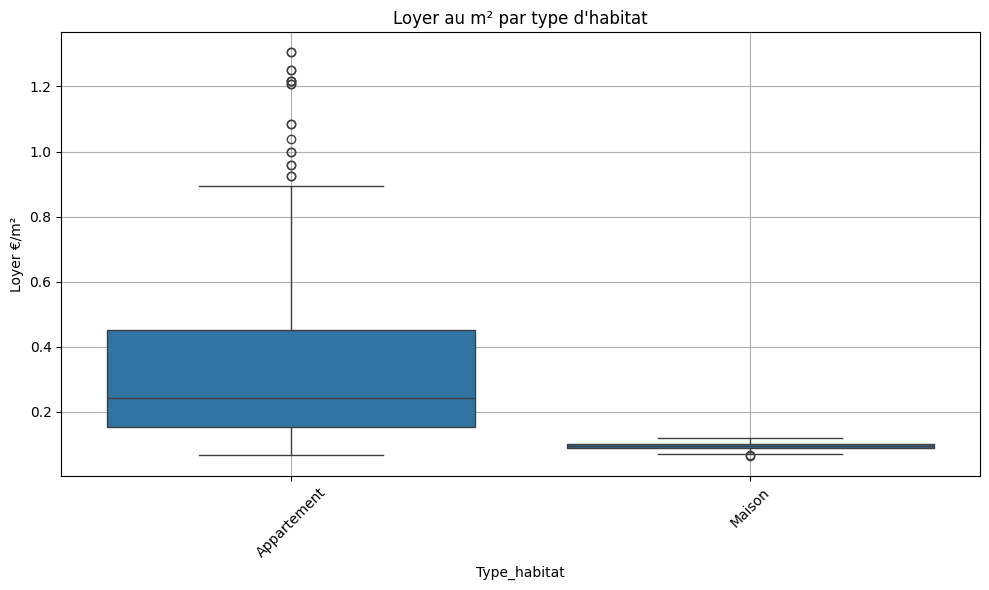

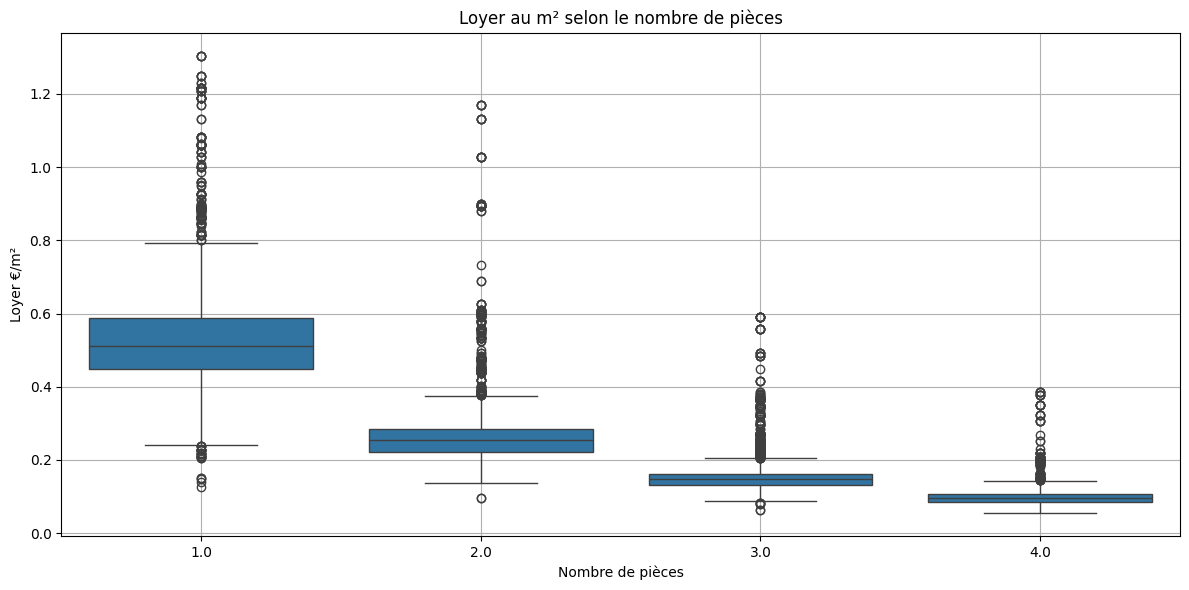

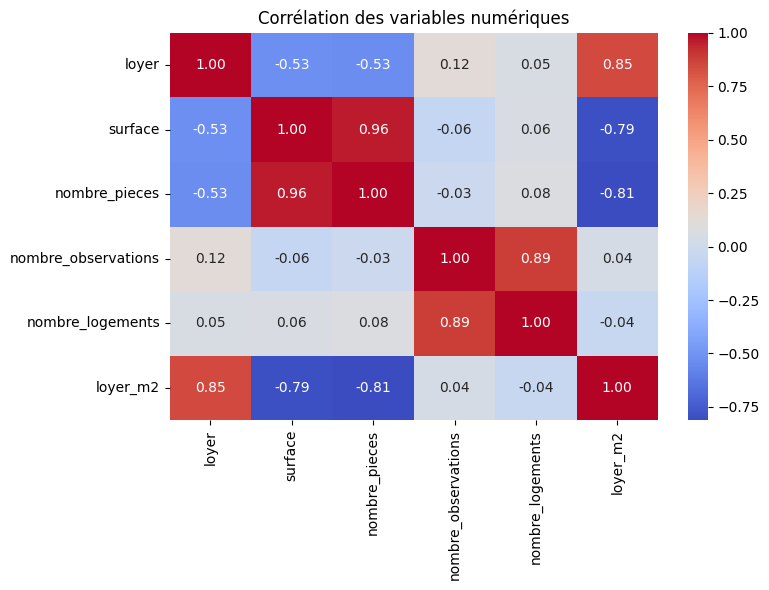

<ipython-input-10-e1c0cca21438>:127: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

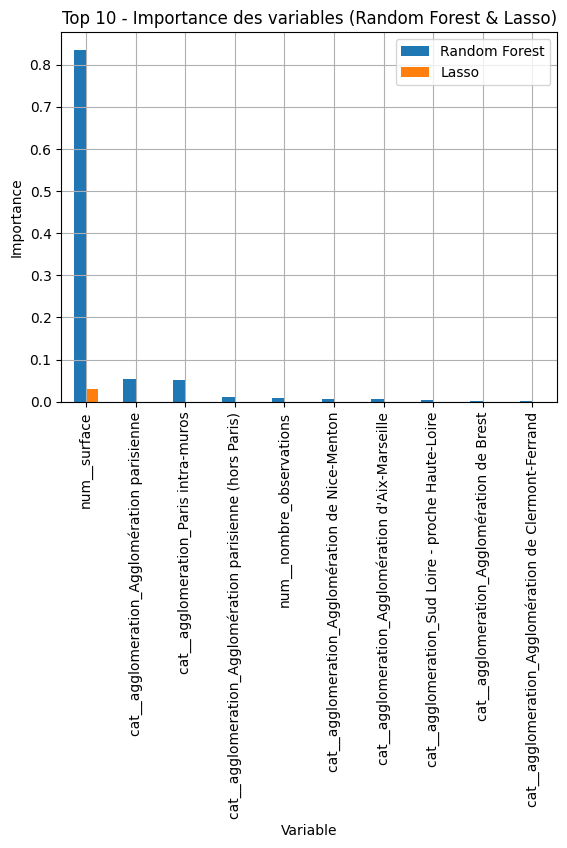

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# ==============================
# 📌 Chargement des données nettoyées
# ==============================
DATA_DIR = "data"
CLEAN_FILE = os.path.join(DATA_DIR, "loyers_clean.csv")

df = pd.read_csv(CLEAN_FILE, encoding="ISO-8859-1")
print("✅ Données chargées :", df.shape)

# 🔧 Nettoyage des noms de colonnes
df.columns = df.columns.str.strip()

# ==============================
# 📊 Statistiques descriptives
# ==============================
print("\n📊 Statistiques descriptives de 'loyer_m2' :")
print(df["loyer_m2"].describe())

# ==============================
# 📊 Histogramme du loyer au m²
# ==============================
plt.figure(figsize=(10, 5))
sns.histplot(df["loyer_m2"], kde=True, bins=30, color="steelblue", edgecolor="black")
plt.title("Distribution du loyer au m²")
plt.xlabel("Loyer (€/m²)")
plt.ylabel("Nombre de logements")
plt.grid(True)
plt.tight_layout()
plt.show()

# ==============================
# 📊 Boxplots par variables catégorielles
# ==============================
plt.figure(figsize=(10, 6))
sns.boxplot(x="Type_habitat", y="loyer_m2", data=df)
plt.title("Loyer au m² par type d'habitat")
plt.ylabel("Loyer €/m²")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x="nombre_pieces", y="loyer_m2", data=df)
plt.title("Loyer au m² selon le nombre de pièces")
plt.xlabel("Nombre de pièces")
plt.ylabel("Loyer €/m²")
plt.grid(True)
plt.tight_layout()
plt.show()

# ==============================
# 📊 Corrélation des variables numériques
# ==============================
numeric_cols = ["loyer", "surface", "nombre_pieces", "nombre_observations", "nombre_logements", "loyer_m2"]
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corrélation des variables numériques")
plt.tight_layout()
plt.show()

# ==============================
# 📈 Importance des variables
# ==============================
numerical_cols = ["surface", "nombre_pieces", "nombre_observations", "nombre_logements"]
categorical_cols = ["agglomeration", "Zone_complementaire", "Type_habitat", "epoque_construction_homogene"]

# Préparation du pipeline
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, numerical_cols),
    ("cat", cat_pipeline, categorical_cols)
])

# Séparation des données
X = df[numerical_cols + categorical_cols]
y = df["loyer_m2"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)
feature_names = preprocessor.get_feature_names_out()

# Modèles
rf = RandomForestRegressor(n_estimators=100, random_state=42)
lasso = Lasso(alpha=0.01)

rf.fit(X_train_transformed, y_train)
lasso.fit(X_train_transformed, y_train)

# Importances
importance_df = pd.DataFrame({
    "Variable": feature_names,
    "Random Forest": rf.feature_importances_,
    "Lasso": np.abs(lasso.coef_)
}).sort_values(by="Random Forest", ascending=False).head(10)

# 📊 Affichage
plt.figure(figsize=(12, 6))
importance_df.set_index("Variable").plot(kind="bar")
plt.title("Top 10 - Importance des variables (Random Forest & Lasso)")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(True)
plt.show()


✅ Données chargées

📊 Comparaison des performances :
                Modèle    RMSE     MAE      R²
0  Régression Linéaire  0.0741  0.0559  0.8323
1                Lasso  0.1033  0.0734  0.6739
2        Random Forest  0.0124  0.0057  0.9953


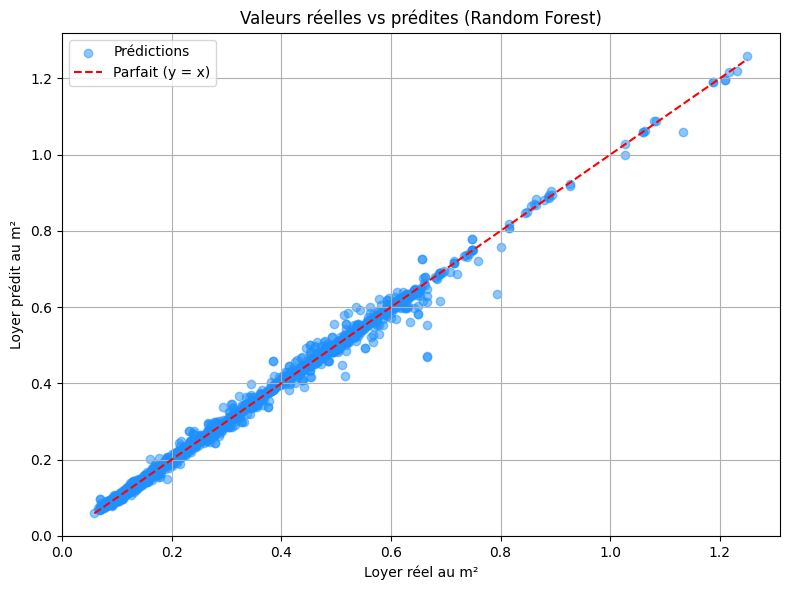


🔍 Top 10 des prédictions les plus éloignées :
       surface  nombre_pieces  Valeur réelle  Valeur prédite  Erreur absolue
3184      27.0            1.0       0.666667        0.469611        0.197056
12778     27.0            1.0       0.666667        0.471425        0.195241
978       27.0            1.0       0.792593        0.633846        0.158747
4190      30.0            1.0       0.666667        0.553896        0.112771
13086     31.0            1.0       0.516129        0.418254        0.097875
2459      27.0            1.0       0.688889        0.615415        0.073474
9701      29.0            1.0       0.634483        0.561958        0.072525
2337      28.0            1.0       0.385714        0.457700        0.071985
8193      28.0            1.0       0.385714        0.457700        0.071985
408       25.0            1.0       1.132000        1.060043        0.071957
📁 Fichier 'top_erreurs_random_forest.xlsx' exporté avec succès.


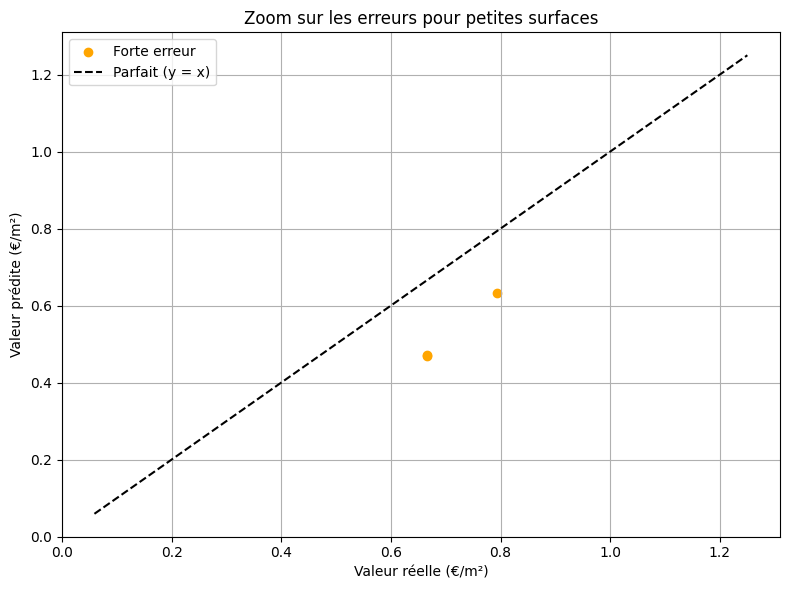

📌 Nombre de cas à forte erreur et petite surface : 3


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==============================
# 📌 Chargement des données
# ==============================
DATA_FILE = "data/loyers_clean.csv"
df = pd.read_csv(DATA_FILE, encoding="ISO-8859-1")
print("✅ Données chargées")

# ==============================
# 📌 Cible et variables explicatives
# ==============================
target = "loyer_m2"
y = df[target]
features = [
    "surface", "nombre_pieces", "nombre_observations", "nombre_logements",
    "agglomeration", "Zone_complementaire", "Type_habitat", "epoque_construction_homogene"
]
X = df[features].copy()

# ==============================
# 📌 Gestion des valeurs manquantes
# ==============================
for col in X.select_dtypes(include=["number"]).columns:
    X[col] = X[col].fillna(X[col].mean())
for col in X.select_dtypes(include=["object"]).columns:
    X[col] = X[col].fillna("Inconnu")

# ==============================
# 📌 Split Train/Test
# ==============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test_original = X_test.copy()

# ==============================
# 📌 Prétraitement
# ==============================
numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# ==============================
# 📌 Entraînement de plusieurs modèles
# ==============================
models = {
    "Régression Linéaire": LinearRegression(),
    "Lasso": Lasso(alpha=0.01),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42)
}

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Modèle": name,
        "RMSE": round(rmse, 4),
        "MAE": round(mae, 4),
        "R²": round(r2, 4)
    })

# Affichage des résultats
print("\n📊 Comparaison des performances :")
results_df = pd.DataFrame(results)
print(results_df)

# ==============================
# 📌 Utilisation du meilleur modèle (Random Forest)
# ==============================
best_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=200, max_depth=None, random_state=42))
])
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

# ==============================
# 📈 Graphe Prédictions vs Réel
# ==============================
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5, color="dodgerblue", label="Prédictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color="red", label="Parfait (y = x)")
plt.xlabel("Loyer réel au m²")
plt.ylabel("Loyer prédit au m²")
plt.title("Valeurs réelles vs prédites (Random Forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==============================
# 📌 Récupération des erreurs
# ==============================
df_test = X_test.copy()
df_test["Valeur réelle"] = y_test.values
df_test["Valeur prédite"] = y_pred_best
df_test["Erreur absolue"] = np.abs(y_test.values - y_pred_best)

# ==============================
# 🧪 Analyse des erreurs
# ==============================
top_erreurs = df_test.sort_values(by="Erreur absolue", ascending=False).head(10)
print("\n🔍 Top 10 des prédictions les plus éloignées :")
print(top_erreurs[["surface", "nombre_pieces", "Valeur réelle", "Valeur prédite", "Erreur absolue"]])

# 📁 Export Excel
top_erreurs.to_excel("top_erreurs_random_forest.xlsx", index=False)
print("📁 Fichier 'top_erreurs_random_forest.xlsx' exporté avec succès.")

# ==============================
# 🔍 Zoom graphique sur erreurs
# ==============================
outliers = df_test[(df_test["Erreur absolue"] > 0.1) & (df_test["surface"] < 30)]

plt.figure(figsize=(8, 6))
plt.scatter(outliers["Valeur réelle"], outliers["Valeur prédite"], color="orange", label="Forte erreur")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label="Parfait (y = x)")
plt.xlabel("Valeur réelle (€/m²)")
plt.ylabel("Valeur prédite (€/m²)")
plt.title("Zoom sur les erreurs pour petites surfaces")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"📌 Nombre de cas à forte erreur et petite surface : {len(outliers)}")
